In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 3: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | Year and name of the fire                                    
| Times_burned                | The number of times tree was burned                                             
| Species                     | First two letters of genus and species                                                    
| Genus_species               | Genus and species of tree                                      
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

# Preview the data
trees_dat.head(3)

/tmp/ipykernel_1473270/1466932731.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,...,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
0,2006 - Tripod,2TREE,Prichard,1,NaN,188,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
1,2006 - Tripod,2TREE,Prichard,1,NaN,74,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
2,2006 - Tripod,2TREE,Prichard,1,NaN,193,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [3]:
# Filter columns to variables of interest
trees_dat = trees_dat[["YrFireName", "Times_burned", "Species",
                       "yr1status", "Genus_species", "DBH_cm", 
                       "HT_m", "CR_pre", "CR_post"]]
# Confirm the remaining columns are correct
trees_dat.columns

Index(['YrFireName', 'Times_burned', 'Species', 'yr1status', 'Genus_species',
       'DBH_cm', 'HT_m', 'CR_pre', 'CR_post'],
      dtype='object')

In [4]:
# Drop all rows with missing values
trees_dat = trees_dat.dropna()

# Confirm there are no NAs 
trees_dat.isna().sum()

YrFireName       0
Times_burned     0
Species          0
yr1status        0
Genus_species    0
DBH_cm           0
HT_m             0
CR_pre           0
CR_post          0
dtype: int64

In [5]:
print(f"Number of observations: {len(trees_dat)}")

Number of observations: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [6]:
# Check the data types
trees_dat.dtypes

YrFireName        object
Times_burned       int64
Species           object
yr1status        float64
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

In [7]:
# Recode categorical predictors to zero-based integer form
for col in ['Genus_species', 'YrFireName', 'Species']:
    trees_dat[f"{col}_cat"] = trees_dat[col].astype('category').cat.codes

# Check the data types
trees_dat.dtypes

YrFireName            object
Times_burned           int64
Species               object
yr1status            float64
Genus_species         object
DBH_cm               float64
HT_m                 float64
CR_pre               float64
CR_post              float64
Genus_species_cat       int8
YrFireName_cat          int8
Species_cat             int8
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [8]:
# Select predictors and outcomes
X = trees_dat.drop(['Species', 'Genus_species', 'YrFireName', 'yr1status'], axis = 1) # Remove the original categorical columns
y = trees_dat["yr1status"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scale the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [9]:
# Calculate the number of observations in for both train and test
train_obs = len(X_train)
test_obs = len(X_test)

# Verify the training and testing set size
print("Training set observations:", train_obs)
print("Testing set observations:", test_obs)

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [10]:
# Fit logistic classifier on training data
model = LogisticRegression().fit(X_train_scaled, y_train)

# Make predictions using model and training data
y_train_pred = model.predict(X_train_scaled)

# Calculate the accuracy of the model
accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {accuracy_train * 100:.3f}%")

Training Accuracy: 94.506%


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 94.020%


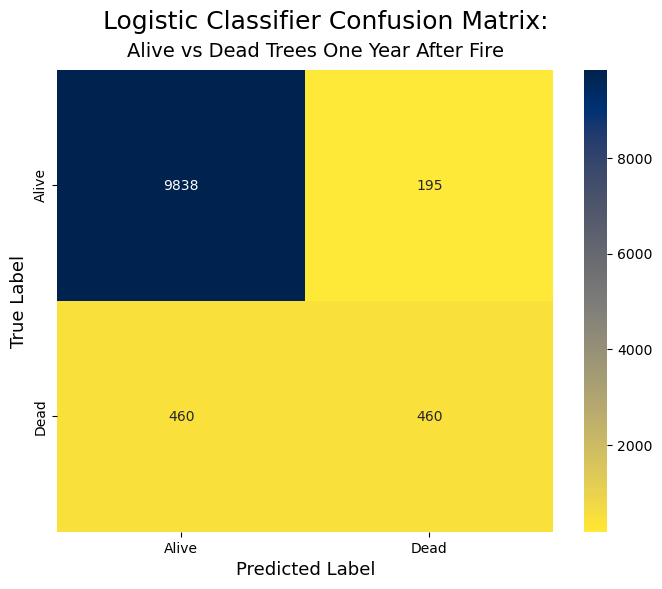

In [11]:
# Make predictions using model and test data
y_test_pred = model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy_test = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy_test * 100:.3f}%")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm, fmt = 'd', cmap = 'cividis_r', xticklabels = ['Alive', 'Dead'],
               yticklabels = ['Alive', 'Dead'], annot = True)
plt.suptitle('Logistic Classifier Confusion Matrix:', fontsize = 18, x = 0.46)
plt.title('Alive vs Dead Trees One Year After Fire', fontsize = 14, x = 0.52, y = 1.01)
plt.ylabel('True Label', fontsize = 13)
plt.xlabel('Predicted Label', fontsize = 13)
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

In [12]:
# Calculate the sensitivity and specificity metrics using the confusion matrix
TN = cm[1,1]
TP = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

sensitivity = TP / (TP + FN) 
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.96
Specificity: 0.70


Our model performed well, with an accuracy of nearly 94%, but does perform differently on observations of living trees versus those that burned. Our true positive rate is 0.95, while our true negative rate is only 0.72. Because there are many more dead trees than there are living ones, there is a class imblnce in the data itself.

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

I would predict that the model would still be relatively accurate because it is using data from the majority class, but not as accurate than if it were also considereing dead trees.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 91.724%

Dummy Confusion Matrix:


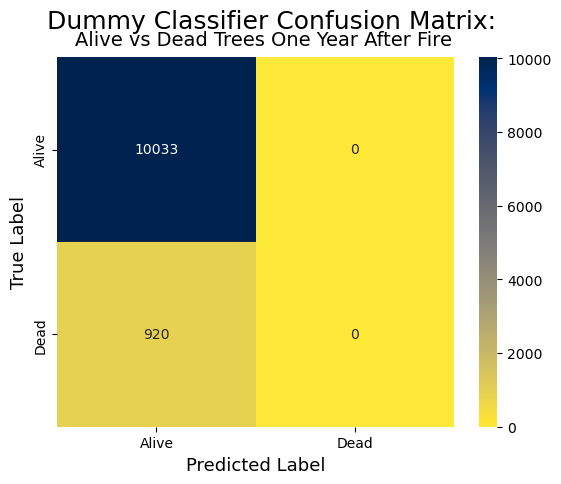

In [13]:
# Create and fit majority classifier
dummy_classifier = DummyClassifier(strategy = "most_frequent")
dummy_classifier.fit(X_train_scaled, y_train)

# Predict using the training data
dummy_train_pred = dummy_classifier.predict(X_train_scaled)

# Predict using the test data
dummy_test_pred = dummy_classifier.predict(X_test_scaled)

# Calculate the accuracy
dummy_accuracy = accuracy_score(y_train, dummy_train_pred)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_accuracy * 100:.3f}%")
print("\nDummy Confusion Matrix:")

cm = confusion_matrix(y_test, dummy_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='cividis_r', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.suptitle('Dummy Classifier Confusion Matrix:', fontsize = 18, x = 0.46)
plt.title('Alive vs Dead Trees One Year After Fire', fontsize = 14, x = 0.52, y = 1.01)
plt.ylabel('True Label', fontsize = 13)
plt.xlabel('Predicted Label', fontsize = 13)
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [14]:
# Logistic classifier AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Logistic AUC: {roc_auc:.4f}")

Logistic AUC: 0.9181


In [15]:
# Dummy classifier AUC
dummy_pred_prob = dummy_classifier.predict_proba(X_test_scaled)[:, 1]
dummy_roc_auc = roc_auc_score(y_test, dummy_pred_prob)

print(f"Dummy AUC: {dummy_roc_auc:4f}")

Dummy AUC: 0.500000


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

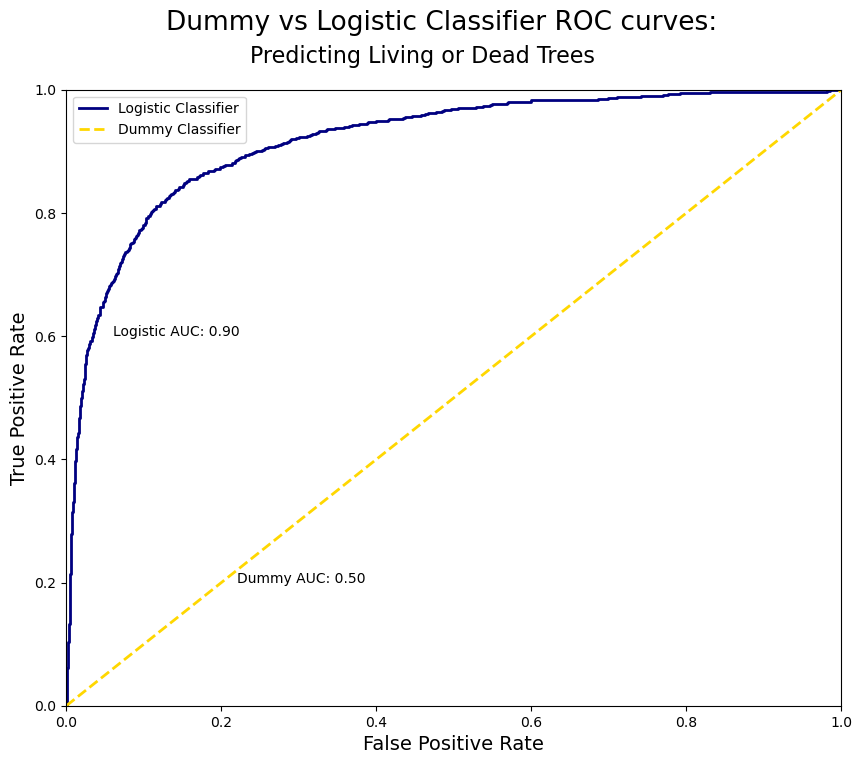

In [16]:
# Create ROC curve for logistic classifier model
fpr_log, tpr_log,  threshold_log = roc_curve(y_test, y_pred_prob)

# Create ROC curve for dummy model
fpr_dummy, tpr_dummy, threshold_dummy = roc_curve(y_test, dummy_pred_prob)

# PLot both curves
plt.figure(figsize = (10, 8))

# Have the origin set to 0,0
plt.xlim(left = 0)  
plt.ylim(bottom = 0)  

# PLot curves
plt.plot(fpr_log, tpr_log, # log model curve
         lw = 2,
         color = 'navy',
         label = 'Logistic Classifier') 
plt.plot(fpr_dummy, tpr_dummy,  # Dummy model curve
         lw = 2,
         linestyle = '--',
         color = 'gold',
         label = 'Dummy Classifier')

# Labels & annotations
plt.suptitle('Dummy vs Logistic Classifier ROC curves:',  fontsize = 19, x = 0.5)
plt.title('Predicting Living or Dead Trees', fontsize = 16, x = 0.46, y = 1.03)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate',  fontsize = 14)
plt.legend(loc = "best")
plt.annotate('Logistic AUC: 0.90',xy = (0.06, 0.6))
plt.annotate('Dummy AUC: 0.50',xy = (0.22, 0.2))
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

While the dummy classifier model has only 0.50 of the total area under the curve, the logistic classifier model has much more, 0.90. An AUC of 0.50 means that the model is effectively random, meaning that the model does not perform well despite the previously reported high accuracy. An AUC of 0.90 means that the model can amke correct predictions 90% of the time. The discrepencies between AUC and accuracy underscore the risk of evaluating a model using accuracy alone.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [17]:
# Create list of feature names
features = X.columns

# Create list of coefficients
coefs = list(model.coef_[0])

# Create df of important features and their corresponding coefficients
importance_df = pd.DataFrame(zip(features, coefs), columns = ['Feature', 'Coefficient'])

# Print the sorted df
print(importance_df.sort_values(by = 'Coefficient', key = abs, ascending = False).to_string(index = False))

          Feature  Coefficient
          CR_post    -2.494974
             HT_m    -1.165414
   YrFireName_cat    -0.660497
      Species_cat     0.541509
           DBH_cm     0.421324
           CR_pre     0.123414
Genus_species_cat    -0.067867
     Times_burned     0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The features that were most significant to our model were the post-fire live crown ratio('CR_post') and the pre-fire tree height in meters('HT_m'). Both of these features relate to the physical nature of trees, so it can be inferred that larger trees are more fire-resistant and have a better chance of surviviing one year after a wildfire. It makes intuitive sense that the relative size of tree crowns can help predict mortality, and becuase 'CR_post' is affected by 'HT_m' it may also be concluded that larger trees have a better survivability. In terms of forest conservation and managemet, this model would suggest that reducing the number of smaller trees that are more likely to burn in a wildfire would be advantageous in reducing fire risk and reducing tree mortality.